In [3]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
pd.set_option("display.expand_frame_repr", False)
import matplotlib.pyplot as plt

from scatspectra.frontend import (
    load_data,
    analyze,
    generate,
    plot_raw,
    plot_dashboard,
    plot_marginal_moments,
    plot_phase_envelope_spectrum,
)
from scatspectra.data_source import SPDaily
from scatspectra.layers.filter_bank import init_band_pass, init_low_pass
from scatspectra.layers.statistics import TimeAverage, AvgPooling, WindowSelector

CACHE_PATH = Path(os.getcwd()) / "_cache"
CACHE_PATH.mkdir(exist_ok=True)
CUDA = torch.cuda.is_available()

if not CUDA:
    print("CUDA is not available: some computations will be slowed-down")

# 1. Analysis of time-series

### Available data

Model fbm: using cache directory fbm_B64_T6063_H5_0e_01.
Model MRW: using cache directory MRW_B64_T6063_L6063_H5_0e_01_la2_0e_01.


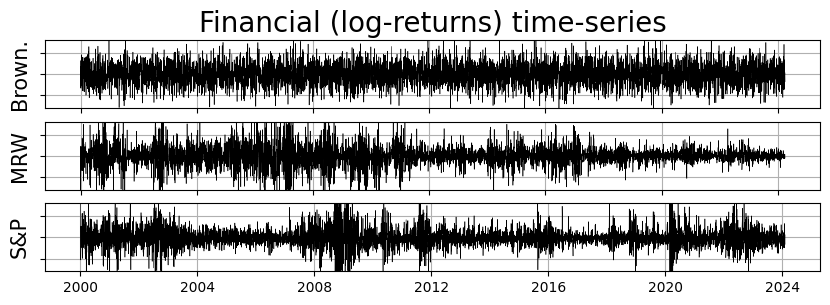

In [2]:
# the function "load_data" provides data from standard models as well as historical data of SP500

# Brownian motion
x_brownian = load_data(
    name="fbm",
    R=128,
    T=6063,  # 1 realization of 6063 time-steps
    H=0.5,  # Hurst exponent, 0.5 for Brownian motion
    cache_path=CACHE_PATH,
)
dx_brownian = np.diff(x_brownian, axis=-1)

# Multifractal Random Walk
x_mrw = load_data(
    name="mrw",
    R=128,
    T=6063,
    H=0.5,  # means no auto-correlation
    lam=0.2,
    cache_path=CACHE_PATH,
)
dx_mrw = np.diff(x_mrw, axis=-1)

# historical daily prices of SP500 from 03-01-2000 to 07-02-2024
data_snp = SPDaily()  # single time-series

################ plotting ####################################
fig, axes = plt.subplots(3, 1, figsize=(10, 3))
axes[0].set_title("Financial (log-returns) time-series", fontsize=20)
axes[0].plot(dx_brownian[0, 0, :], lw=0.4, color="black")
axes[0].set_xticklabels([])
axes[0].set_ylabel(f"Brown.", fontsize=15)
axes[1].plot(dx_mrw[0, 0, :], lw=0.4, color="black")
axes[1].set_xticklabels([])
axes[1].set_ylabel(f"MRW", fontsize=15)
axes[2].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[2].set_ylabel(f"S&P", fontsize=15)
for ax in axes:
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

### Main function: 'analyze'

Row visualization of Scattering Spectra.
See 'Visualization' for a better visualization.


Text(0.5, 1.0, 'Scattering Spectra of white noise (raw visualization)')

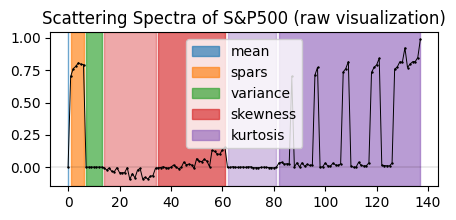

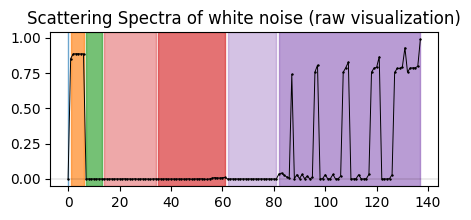

In [3]:
# function 'analyze' computes wavelet-based statistics, e.g. Scattering Spectra:

# Scattering Spectra of S&500
scat_snp = analyze(
    x=data_snp.dlnx,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

# Scattering Spectra of white noise: for comparison
scat_wn = analyze(
    x=dx_brownian,
    model_type="scat_spectra",
    J=6,  # number of scales (see next cells)
)

################ plotting ####################################
# quick plot
print("Row visualization of Scattering Spectra.")
print("See 'Visualization' for a better visualization.")
ax1, _ = plot_raw(scat_snp, legend=True)
ax1.set_title("Scattering Spectra of S&P500 (raw visualization)", fontsize=12)
ax2, _ = plot_raw(scat_wn, legend=False)
ax2.set_title("Scattering Spectra of white noise (raw visualization)", fontsize=12)

In [4]:
# some useful methods. See class DescribedTensor for more methods
print(f"Scattering Spectra shape: \n{scat_snp.y.shape} \n")  # batch_size x num_coeffs x num_times (num_times=1 because time has been averaged)
print(f"Scattering Spectra description shape: \n{scat_snp.df.shape}\n")

# Each coefficient scat_snp.y[:,i,:] is described by the row scat_snp.df.iloc[i]
# For example:
i = 15
print(f"Coefficient {i} is equal to \n{scat_snp.y[0,i,0]:.3f}\nand its description is \n\n{scat_snp.df.iloc[i]}\n")

# some additional information
# 'coeff_type': the coefficient type e.g. spars, variance, skewness, kurtosis
# 'nl': (for multi-variate analysis) the in-channel index of the left-term in a correlation
# 'nr': (for multi-variate analysis) the in-channel index of the right-term in a correlation
# 'q': the order of the moment: 1 for the mean or sparsity factors, 2 for the correlation coefficients (variance, skewness, kurtosis)
# 'rl': the scattering order (number of convolutions) of the left-hand term in a correlation
# 'rr': the scattering order (number of convolutions) of the right-hand term in a correlation
# 'scl': the unique scattering index of the scale path (jl1,j2) of the left-hand term in a correlation
# 'scr': the unique scattering index of the scale path (jr1,j2) of the right-hand term in a correlation
# 'jl1': the scale index of the first wavelet of the left-hand term in a correlation
# 'jr1': the scale index of the first wavelet of the right-hand term in a correlation
# 'j2': the scale index of the second wavelet in a correlation
# 'al': (for image data) the angle of the first wavelet of the left-hand term in a correlation
# 'ar': (for image data) the angle of the first wavelet of the right-hand term in a correlation
# 'is_low': whether this is a low-pass coefficient: the last wavelet corresponds to a low-pass filter

# to access coefficients by their description:
# for example, accessing a skewness coefficients at scale j=2
print("Coefficient selection")
selected_coeff = scat_snp.query(
    coeff_type="skewness", jl1=2, jr1=2
)  # DescribedTensor object
print(selected_coeff.df)
print(selected_coeff.y[0, 0, 0].item(), "\n")
# other example: selecting the sparsity and variance coefficients
selected_coeff = scat_snp.query(coeff_type=["spars", "variance"])
print(selected_coeff.df)
print(selected_coeff.y[0, :, 0])

Scattering Spectra shape: 
torch.Size([1, 97, 1]) 

Scattering Spectra description shape: 
(97, 15)

Coefficient 15 is equal to 
-0.003-0.022j
and its description is 

coeff_type    skewness
is_real          False
nl                   0
nr                   0
q                    2
rl                   1
rr                   2
scl                  1
scr                  8
jl1                  1
jr1                  0
j2                   1
al                   0
ar                   0
is_low           False
Name: 1, dtype: object

Coefficient selection
  coeff_type  is_real  nl  nr  q  rl rr  scl scr jl1 jr1 j2  al ar  is_low
5   skewness    False   0   0  2   1  2    2  20   2   2  2   0  0   False
(-0.0005035312084438052-0.0038799713757243326j) 

  coeff_type  is_real  nl  nr  q  rl    rr  scl   scr jl1   jr1    j2  al    ar  is_low
0      spars     True   0   0  1   1  <NA>    0  <NA>   0  <NA>   NaN   0  <NA>   False
1      spars     True   0   0  1   1  <NA>    1  <NA>   1  <NA>  

### Visualization

For a Scattering Spectra representation, function "plot_dashboard" separates the different coefficients \
and visualize them as 'spectra', as curves along scales.
- 'mean' (1 coeff): the time-average of x: $<x(t)>_t$
- 'spars' (~J coeffs): the sparsity factor of wavelet coefficients at each scale: $<|x\star\psi_j(t)|>_t / \sigma_j$
- 'variance' (~J coeffs): the variance, or energy, of wavelet coefficients at each scale: $\sigma^2_j = <|x\star\psi_j(t)|^2>_t$
- 'skewness' (~J^2/2 coeffs): the cross-scale correlations $<x\star\psi_{j_l}(t)~|x\star\psi_{j_r}(t)|> / (\sigma_{j_l} \sigma_{j_r})$
- 'kurtosis' (~J^3/6 coeffs): the cross-scale correlations $<|x\star\psi_{j_l}|*\psi_{j_2}(t)~|x\star\psi_{j_r}(t)|\star\psi^*_{j_2}(t)> / (\sigma_{j_l} \sigma_{j_r})$

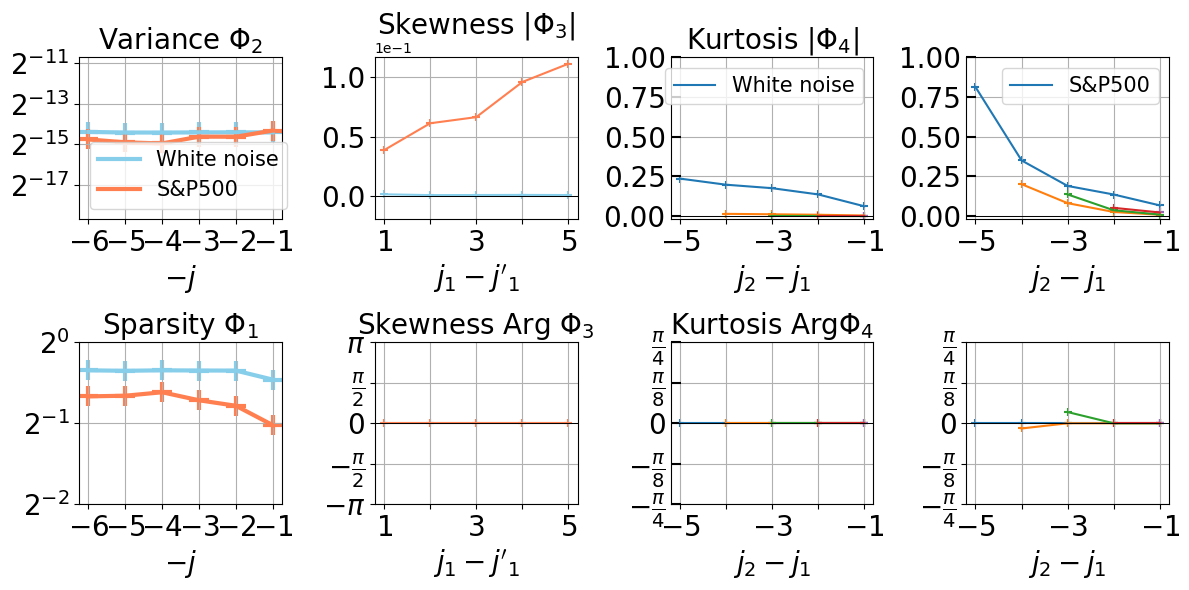

In [5]:
axes = plot_dashboard(
    [scat_wn, scat_snp],
    labels=["White noise", "S&P500"],
    theta_threshold=[0.3, 0.1],  # avoid complex-phase instabilities
    figsize=(12, 6),
)
for ax in [axes[0, 1], axes[1, 0]]:
    ax.legend().remove()

### Interpretation

Can be found in the paper "Scale Dependencies and Self-Similar Models with Wavelet Scattering Spectra" https://arxiv.org/abs/2204.10177

#### sparsity $\Phi_1$, variance $\Phi_2$

'variance' coefficients: the standard power spectrum $\sigma^2_j = <|x\star\psi_j(t)|^2>_t$
\
The power-spectrum of both white noise and S&P500 is flat, as expected:
these time-series are uncorrelated over time.

'sparsity' coefficients: sparsity at different scales $<|x\star\psi_j(t)|>_t / \sigma_j$
\
The level and decay of the curve quantifies intermittency: the lower and the steeper
the curve, the more sparsity. \
For a Gaussian, this curve is flat, at a high level. 
For a financial time-series which presents intermittency, e.g. crisis, 
this curve is low and decreases.

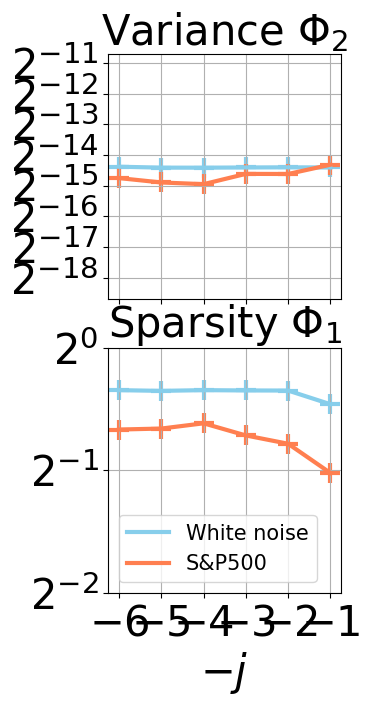

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(3, 7))
plot_marginal_moments([scat_wn, scat_snp], labels=["White noise", "S&P500"], axes=axes)
axes[0].set_xticklabels([])
axes[0].set_xlabel((""))
axes[0].legend().remove()

#### skewness $\Phi_3$

Skewness coefficients: $<x\star\psi_{j_l}(t)~|x\star\psi_{j_r}(t)|> / (\sigma_{j_l} \sigma_{j_r})$

Their modulus quantify the change in $x$ when its sign is changed $-x$. \
A 'skewed' process breaks the sign invariance $x$-> $-x$. \
The larger their modulus the more 'skewed' the process is.

Their complex-phase quantifies time-asymmetry that is the change in the \
process $x$ when the time is reversed $x(-t)$. \
A non-zero phase indicates time-asymmetry.

A Gaussian process is invariant to sign-change and time-reversal, thus, both 
curves are zero. 

The financial time-series is skewed as shown on the graph of $\Phi_3$. \
It has also time-asymmetries, as shown on the graph of Arg $\Phi_3$. \ 
Both are expected -- this is the leverage effect.

Text(0.5, 0, '')

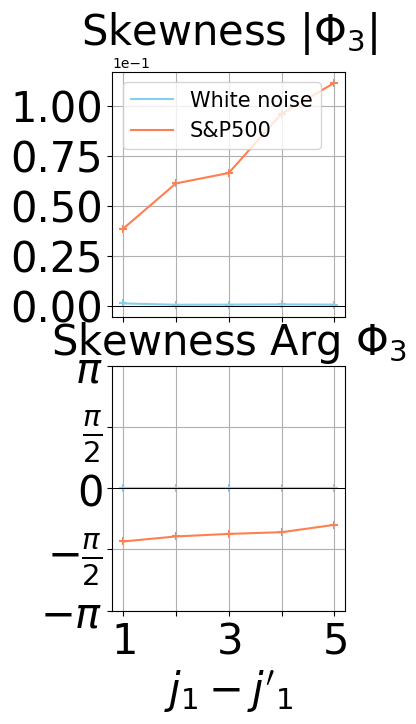

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(3, 7))
plot_phase_envelope_spectrum(
    [scat_wn, scat_snp], labels=["White noise", "S&P500"], axes=axes
)
axes[0].set_xticklabels([])
axes[0].set_xlabel((""))

### Changing the averaging operator

Scattering Spectra are estimated by averaging over the time dimension. \
Other operators are available such as average pooling. \
They can be provided through the 'estim_operator' argument in 'analyze' function. 

In [8]:
# default: Scattering Spectra statistics averaged on the full window
estim_operator = None
scat_wn = analyze(
    x=np.random.randn(1024),
    model_type="scat_spectra",
    estim_operator=None,
)
print("Output time shape", scat_wn.y.shape[-1])

# window selection: Scattering Spectra at each time: no average
window = np.arange(12, 1024 - 12)
estim_operator = WindowSelector(window=window)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

# average on a given window e.g. the middle 512 samples
estim_operator = TimeAverage(window=window)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

# average pooling
estim_operator = AvgPooling(kernel_size=2, stride=2)
scat_wn = analyze(
    x=np.random.randn(1024), model_type="scat_spectra", estim_operator=estim_operator
)
print("Output time shape", scat_wn.y.shape[-1])

Output time shape 1
Output time shape 1000
Output time shape 1
Output time shape 512


### Choosing the hyper-parameters

Every parameter of 'analyze' admits a default value so that the only parameter
to provide is the data to analyze.

However, if you want to explore changes in the wavelet parameter, 
the generative algorithm etc ... here are some guidelines.

#### wavelet parameters high_freq, J, Q

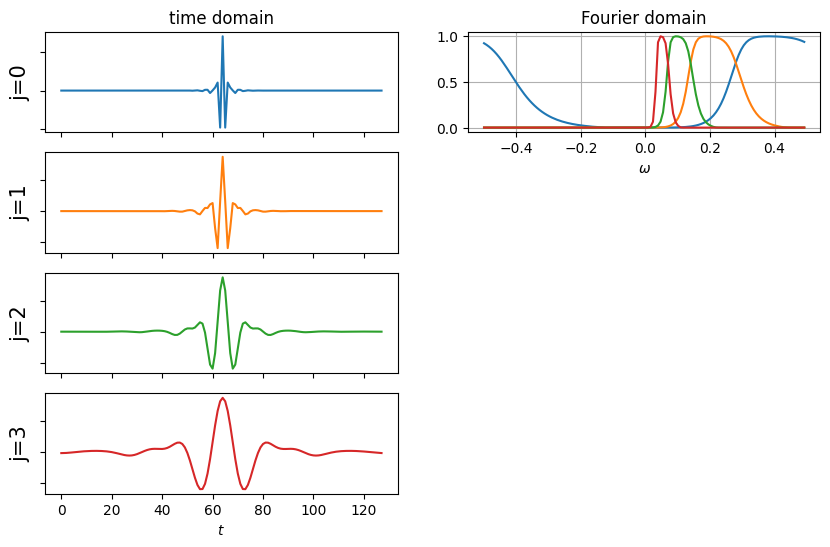

In [10]:
# plotting the wavelet filters


def get_wavelets_psi(T, J, Q, wav_type, high_freq):
    psi_hat = torch.tensor(init_band_pass(wav_type, T, J, Q, high_freq, wav_norm="l1"))
    psi = torch.fft.ifft(psi_hat)
    psi = torch.roll(psi, shifts=(psi.shape[-1]//2,), dims=(-1,))
    return psi, psi_hat


def get_wavelet_phi(T, J, Q, wav_type, high_freq):
    phi_hat = torch.tensor(init_low_pass(wav_type, T, J, Q, high_freq))
    phi = torch.fft.ifft(phi_hat)
    phi = torch.roll(phi, shifts=(phi.shape[-1]//2,), dims=(-1,))
    return phi, phi_hat


T = 128
J = 4

filter, psi_hat = get_wavelets_psi(
    T, J=J, Q=1, wav_type="battle_lemarie", high_freq=0.425
)
freq = torch.fft.fftfreq(T)

################ plotting ####################################
_, axes = plt.subplots(J, 2, figsize=(10, 6))
axes[0, 0].set_title("time domain")
axes[0, 1].set_title("Fourier domain")
axes[0, 1].plot(torch.fft.fftshift(freq), torch.fft.fftshift(psi_hat, dim=-1).real.T)
axes[0, 1].grid(True)
axes[-1, 0].set_xlabel("$t$")
axes[0, 1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for j in range(J):
    color = colors[j % len(colors)]
    axes[j, 0].plot(filter[j, :].real, color=color)
    axes[j, 0].set_ylabel(f"j={j}", fontsize=15)
    if j > 0:
        axes[j, 1].remove()
    if j < J - 1:
        axes[j, 0].set_xticklabels([])
    if j < J:
        axes[j, 0].set_yticklabels([])

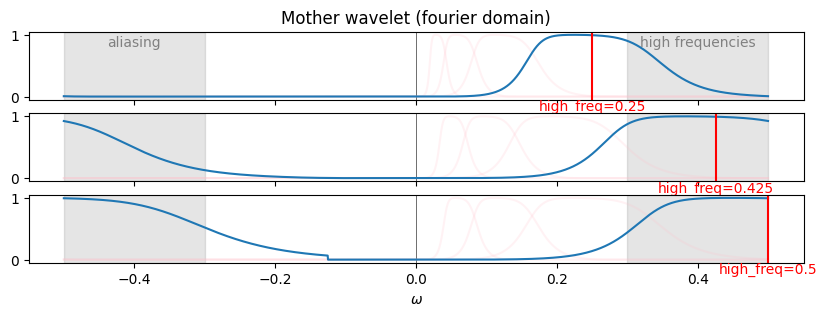

In [11]:
# parameter 'high_freq'
# the central frequency of the mother wavelet
# 0.0 < high_freq < 0.5, default=0.425 for "battle_lemarie" wavelets

# the choice of high_freq is ruled by the following trade-off
# 1. the energy of the mother wavelet on negative frequencies should be
# as small as possible (because this breaks the fact that other band-pass filters
# are obtained by dilation)
# 2. the mother wavelet should cover high-frequency (omega~<0.5)

# we consistently take high_freq=0.425 for battle-lemarie wavelets:
# below:
# high_freq=0.25: high-frequencies are partially covered
# high_freq=0.425: small aliasing and high-frequencies are covered
# high_freq=0.5: too much aliasing

T = 2048

high_freqs = [0.25, 0.425, 0.5]
psis_hat = [
    get_wavelets_psi(T, J=8-4, Q=1, wav_type="battle_lemarie", high_freq=high_freq)[1]
    for high_freq in high_freqs
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(high_freqs), 1, figsize=(10, 3))
axes[0].set_title("Mother wavelet (fourier domain)")
axes[-1].set_xlabel("$\omega$")
axes[0].text(
    -0.4,
    0.95,
    "aliasing",
    color="gray",
    transform=axes[0].get_xaxis_transform(),
    ha="center",
    va="top",
)
axes[0].text(
    0.4,
    0.95,
    "high frequencies",
    color="gray",
    transform=axes[0].get_xaxis_transform(),
    ha="center",
    va="top",
)
for i in range(len(high_freqs)):
    if i < 2:
        axes[i].set_xticklabels([])
    axes[i].axvline(0.0, color="black", lw=0.4)
    axes[i].plot(
        torch.fft.fftshift(freqs),
        torch.fft.fftshift(psis_hat[i][1:, :], dim=-1).real.T,
        color="pink",
        alpha=0.2,
    )
    axes[i].plot(
        torch.fft.fftshift(freqs),
        torch.fft.fftshift(psis_hat[i][0, :], dim=-1).real,
        label=f"high_freq={high_freqs[i]}",
    )
    axes[i].axvline(high_freqs[i], color="red")
    axes[i].text(
        high_freqs[i],
        0.0,
        f"high_freq={high_freqs[i]}",
        color="red",
        transform=axes[i].get_xaxis_transform(),
        ha="center",
        va="top",
    )
    axes[i].axvspan(-0.5, -0.3, color="black", alpha=0.1)
    axes[i].axvspan(0.3, 0.5, color="black", alpha=0.1)

tensor(323)
tensor(647)
tensor(1528)


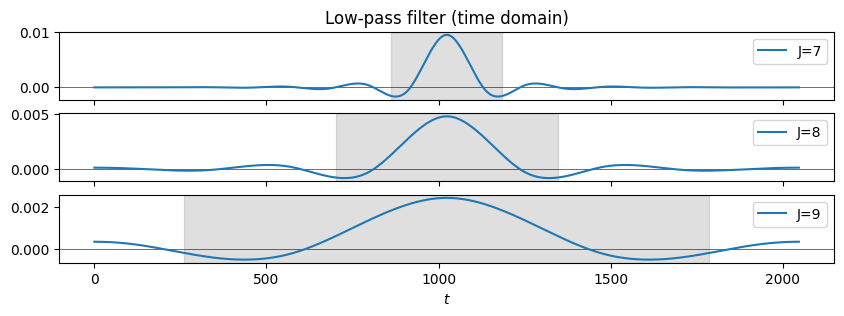

In [12]:
# parameter 'J'
# the number of scales
# 1 < J, default~=log_2(T)-3 for "battle_lemarie" wavelets

# the choice of J is ruled by a tradeoff
# 1. J should be large enough for the model to capture long-range dependencies
# 2. J should be small enough for the largest-scale coefficients to be well-estimated

# below:
# J = log_2(T)-4: the low-pass wavelet support is of the order of 12% of the
#       time-series size: long-range dependencies, if any, won't be captured well
# J = log_2(T)-3: the low-pass wavelet support is of the order of 25%.
#       Intuitively, the average <|x*\phi(t)|^2> is thus made on 4 points.
#       (Number of non-overlapping support intervals that can put on the time-series).
# J = log_2(T)-2: the low-pass wavelet support is of the order of 50%.
#       Intuitively, the average <|x*\phi(t)|^2> is made on 2 points, which
#       yields a large-variance estimator.

T = 2048


def get_support_size(filter, threshold=0.10):
    threshold = filter.abs().max() * threshold
    size = (filter.abs() > threshold).sum(-1)
    idx_max = filter.abs().argmax(-1)
    idces = torch.arange(idx_max - size // 2, idx_max + size // 2)
    return size, idces


J_choosen = int(np.log2(T)) - 3
Js = [J_choosen - 1, J_choosen, J_choosen + 1]
phis = [
    get_wavelet_phi(T, J=J, Q=1, wav_type="battle_lemarie", high_freq=0.425)[0]
    for J in Js
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(Js), 1, figsize=(10, 3))
axes[0].set_title("Low-pass filter (time domain)")
axes[-1].set_xlabel("$t$")
for i in range(len(Js)):
    axes[i].axhline(0.0, color="black", lw=0.4)
    s, idces = get_support_size(phis[i])
    print(s)
    axes[i].axvspan(idces.min(), idces.max(), color="gray", alpha=0.25)
    if i < 2:
        axes[i].set_xticklabels([])
    axes[i].plot(phis[i].real, label=f"J={Js[i]}")
    axes[i].legend()

/tmp/ipykernel_3115323/100696884.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  torch.fft.fftshift(wav_hat, dim=-1).real.T,


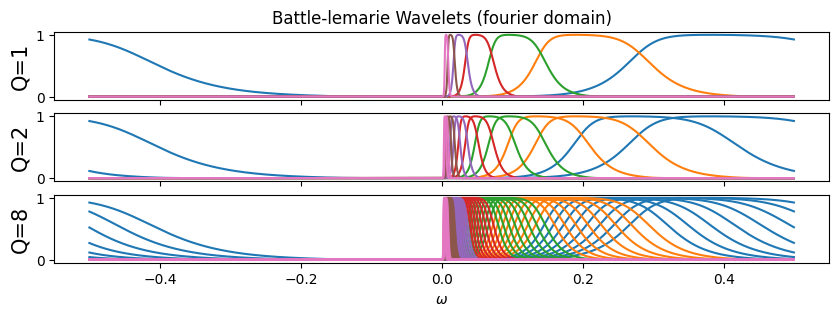

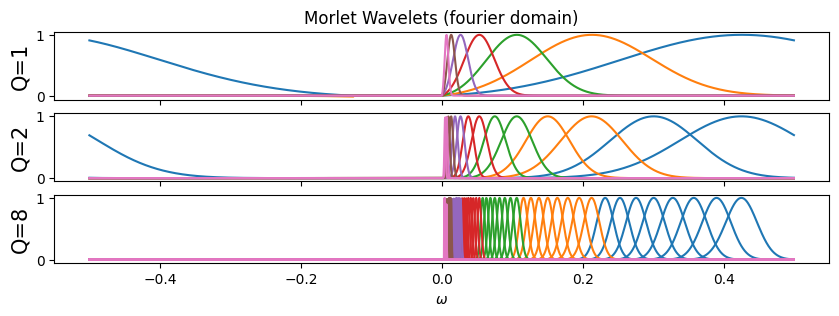

In [13]:
# parameter 'Q'
# the number of wavelets per scale
# 1 <= Q, default=1

# increasing Q has the following behavior depending on the wavelet
# 1. for "battle_lemarie" wavelets, increasing Q will introduce intermediate
# dilation steps: 2^(j/Q) from one filter to the other
# 2. for "morlet" wavelets, increasing Q increases the frequency resolution of
# each wavelet
# (these two separate behaviors has nothing to do with the type of wavelet,
# they are just a code artefact)

# take Q>1 (with "morlet" wavelets) only if the time-series has non-trivial
# structures which require better frequency resolution to be characterized

T = 2048

J = int(np.log2(T)) - 4
Qs = [1, 2, 8]
psis_hat_bl = [
    get_wavelets_psi(T, J=J, Q=Q, wav_type="battle_lemarie", high_freq=0.425)[1]
    for Q in Qs
]
psis_hat_morlet = [
    get_wavelets_psi(T, J=J, Q=Q, wav_type="morlet", high_freq=0.425)[1] for Q in Qs
]
freqs = torch.fft.fftfreq(T)

################ plotting ####################################
fig, axes = plt.subplots(len(Qs), 1, figsize=(10, 3))
axes[0].set_title("Battle-lemarie Wavelets (fourier domain)")
axes[-1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(len(Qs)):
    if i < 2:
        axes[i].set_xticklabels([])
    for j, wav_hat in enumerate(psis_hat_bl[i]):
        axes[i].plot(
            torch.fft.fftshift(freqs),
            torch.fft.fftshift(wav_hat, dim=-1).real.T,
            color=colors[j // Qs[i]],
        )
    axes[i].set_ylabel(f"Q={Qs[i]}", fontsize=15)
fig, axes = plt.subplots(len(Qs), 1, figsize=(10, 3))
axes[0].set_title("Morlet Wavelets (fourier domain)")
axes[-1].set_xlabel("$\omega$")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(len(Qs)):
    if i < 2:
        axes[i].set_xticklabels([])
    for j, wav_hat in enumerate(psis_hat_morlet[i]):
        axes[i].plot(
            torch.fft.fftshift(freqs),
            torch.fft.fftshift(wav_hat, dim=-1).real.T,
            color=colors[j // Qs[i]],
        )
    axes[i].set_ylabel(f"Q={Qs[i]}", fontsize=15)

## Classification of jumps

In [88]:
# useful variables / functions

# the time indices of a jump time-series
ts = np.arange(-59,59+1)

# number of wavelet scales
J = 6

from scatspectra.models import DescribedTensor

def format_description(scat): 
    """ Format the description of a DescribedTensor object. """
    df = scat.df.copy()
    df["c_type"] = [f"r={r}" for r in df.r]
    df["is_real"] = df.is_low
    return DescribedTensor(y=scat.y, df=df)

# reflexivity direction

# mean-reverting direction
mr_filter = np.zeros(ts.size)
mr_filter[ts==-2] = 0.5
mr_filter[ts==-1] = 1.0
mr_filter[ts==1] = -1.0
mr_filter[ts==2] = -0.5

# trend direction
tr_filter = np.zeros(ts.size)
tr_filter[ts==-2] = 0.5
tr_filter[ts==-1] = 1.0
tr_filter[ts==1] = 1.0
tr_filter[ts==2] = 0.5

def compute_mr_score(x):
    """ Compute the mean-reverting score of a time-series. """
    signs = np.sign(x[:,ts==0])
    return (signs*x*mr_filter[None,:]).sum(-1)

def compute_td_score(x):
    """ Compute the trend score of a time-series. """
    signs = np.sign(x[:,ts==0])
    return (signs*x*tr_filter[None,:]).sum(-1)


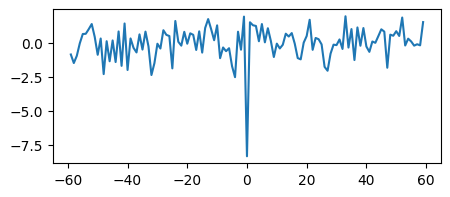

In [96]:
# benchmark data
x_jumps = np.random.randn(16, 119)
x_jumps[:, ts==0] *= 10

# plot
plt.figure(figsize=(5,2))
plt.plot(ts, x_jumps[0,...]);

In [97]:
from scatspectra import format_to_real

# compute scattering coefficients 'scat'
signs = np.sign(x_jumps[:,ts==0])
scat = analyze(signs*x_jumps, model_type=None, J=6, normalize="each_ps", skew_redundance=False)
scat = format_description(scat)
t0 = np.where(ts==0)[0][0]
scat.y = scat.y[:, :, t0:t0+1]
scat.y.shape

# extract second order coefficients Imag(W|Wx|): time-asymmetry of the volatility profile
scat_im = format_to_real(scat.query(is_low=False))
scat_im = scat_im.query(is_real=False, r=2)
scat_im.y = scat_im.y[...,0]

print(scat_im.y.shape)  # the scattering features for each jump
print(scat_im.df.shape)  # the description of the different features

torch.Size([16, 15])
(15, 9)


In [99]:
# compute reflexivity score 
# remove energy of the feature vector
y_reflexivity = scat_im.y / (scat_im.y**2).mean(-1, keepdims=True)**0.5
fake_pca_vector = np.random.randn(15)
y_reflexivity = y_reflexivity @ fake_pca_vector

# compute mean-reversion score
y_mr = compute_mr_score(x_jumps)

# compute trend score
y_td = compute_td_score(x_jumps)


# 2. Generation of time-series

### Main function: 'generate'

In [14]:
# observed data
data_snp = SPDaily()

# generate data
x_gen = generate(
    x=data_snp.dlnx,
    S=1,
    model_type="scat_spectra",
    cache_path=None,  # provide a directory if you want to cache the generations
    cuda=CUDA,  # you are strongly encouraged to use GPU if available
)

Model scattering: generating data ...


  0%|          | 0/1 [00:00<?, ?it/s]

Initialize model
Preparing target representation
Model scat_spectra based on 239 statistics: 
 ---- mean : 1
 ---- spars : 9
 ---- variance : 10
 ---- skewness : 54
 ---- kurtosis : 165
     3it in 0:00:00.52 ( 5.76 it/s ) .... err 1.99E-01
    17it in 0:00:00.86 ( 19.79 it/s ) .... err 9.45E-02
   112it in 0:00:03.28 ( 34.10 it/s ) .... err 1.56E-02
   306it in 0:00:08.26 ( 37.06 it/s ) .... err 3.54E-03


100%|██████████| 1/1 [00:26<00:00, 26.60s/it]

Optimization Exit Message : SmallEnoughException
found parameters in 20.78s, 883 iterations -- 42.49it/s
    abs sqrt error 5.00E-04
    relative gradient error 1.13E-05
    loss0 2.21E-01
Finished.


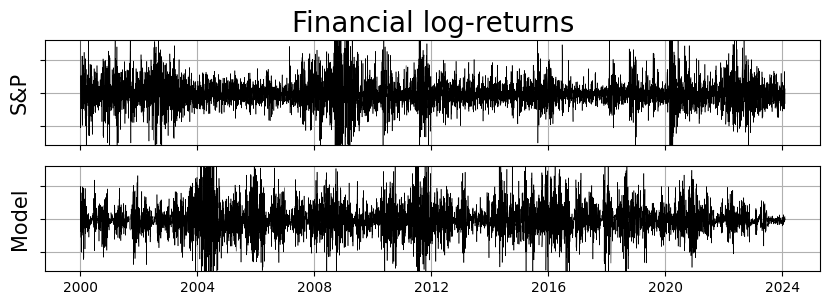

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], x_gen[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"Model", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

## Influence of coefficients in the model

In [17]:
# observed data
data_snp = SPDaily()

x0 = np.random.randn(*data_snp.dlnx.shape)[:, None, :, :]

# generate data with restricted model
# the model associated to this generation imposes only the 'mean' and
# the 'variance' coefficients (power-spectrum) it is thus a Gaussian model
x_gen_1 = generate(
    x=data_snp.dlnx,
    x0=x0,
    S=1,
    model_type="scat_spectra",
    coeff_types=["mean", "variance"],
    cache_path=CACHE_PATH,
    cuda=CUDA,
)

# generate data with restricted model
# this model is non-Gaussian but does not capture long-range dependencies well
x_gen_2 = generate(
    x=data_snp.dlnx,
    x0=x0,
    S=1,
    model_type="scat_spectra",
    coeff_types=["mean", "variance", "spars"],
    cache_path=CACHE_PATH,
    cuda=CUDA,
)

# generate data with full model
x_gen_full = generate(
    x=data_snp.dlnx,
    x0=x0,
    S=1,
    model_type="scat_spectra",
    cache_path=CACHE_PATH,
    cuda=CUDA,
)

Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2__Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1_aemv_ma10000_to5_0e_04__hi0_sk1_nc1__cu1__me_L_BFGS_B_ma2_0e_06_ja1.
Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2__Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1_aempsv_ma10000_to5_0e_04__hi0_sk1_nc1__cu1__me_L_BFGS_B_ma2_0e_06_ja1.
Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2__Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1___ma10000_to5_0e_04__hi0_sk1_nc1__cu1__me_L_BFGS_B_ma2_0e_06_ja1.


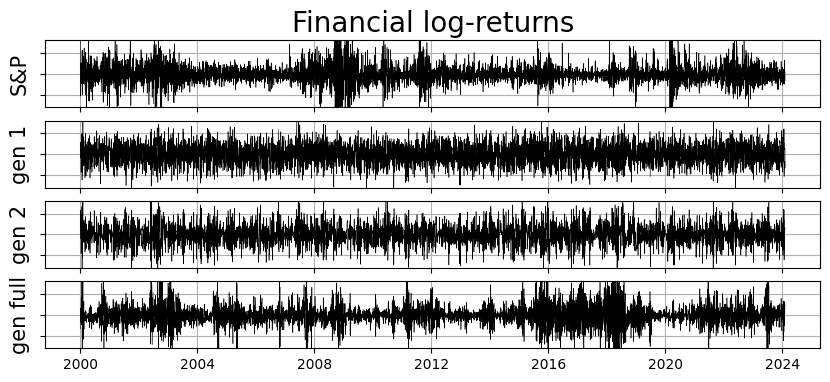

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(10, 4))
axes[0].set_title("Financial log-returns", fontsize=20)
axes[0].plot(data_snp.dts[:-1], data_snp.dlnx[0, 0, :], lw=0.4, color="black")
axes[0].set_ylabel(f"S&P", fontsize=15)
axes[1].plot(data_snp.dts[:-1], x_gen_1[0, 0, :], lw=0.4, color="black")
axes[1].set_ylabel(f"gen 1", fontsize=15)
axes[2].plot(data_snp.dts[:-1], x_gen_2[0, 0, :], lw=0.4, color="black")
axes[2].set_ylabel(f"gen 2", fontsize=15)
axes[3].plot(data_snp.dts[:-1], x_gen_full[0, 0, :], lw=0.4, color="black")
axes[3].set_ylabel(f"gen full", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])

## Generation from adjusted representation

[1.0, 0.8, 0.6]


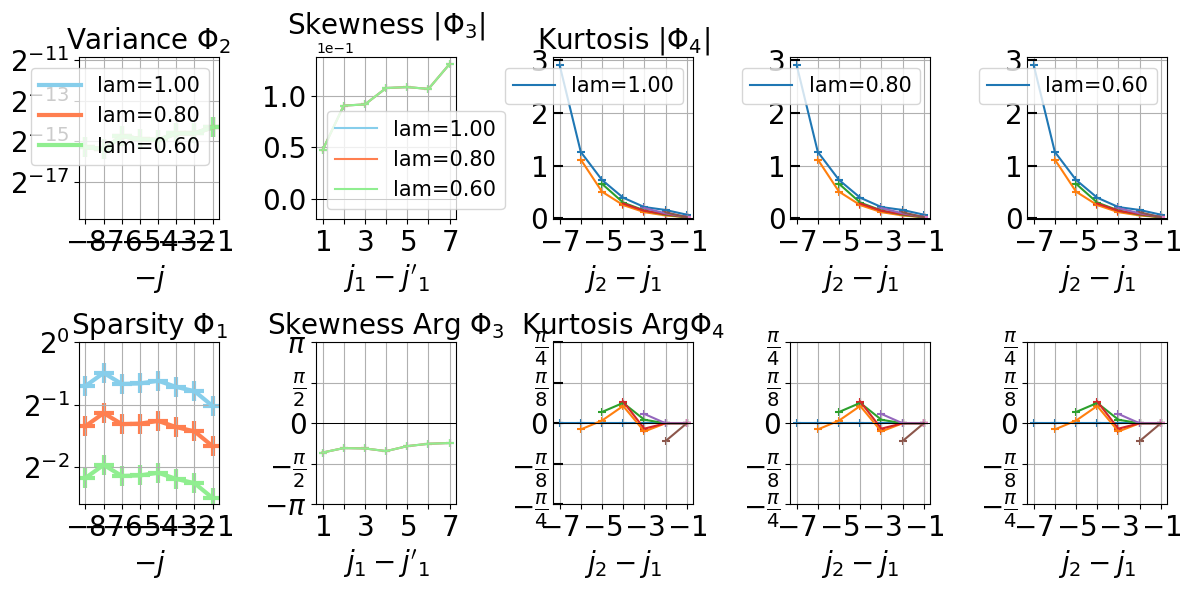

In [19]:
# observed data
data_snp = SPDaily()

# estimate Scattering Spectra on observed data
scat_snp = analyze(x=data_snp.dlnx, model_type="scat_spectra", J=8, cuda=CUDA)

# reference Scattering Spectra of white noise
scat_ref = analyze(
    x=np.random.randn(128, 1, data_snp.dlnx.shape[-1]),
    model_type="scat_spectra",
    J=8,
    cuda=CUDA,
).mean_batch()


def adjust_gaussianity(scat, scat_ref, lam=0.5):
    scat_adj = scat.clone()
    mask = scat_adj.eval("coeff_type=='spars'")
    # scat_adj.y[:,mask,:] = ((1 - lam) * scat_ref.y + lam * scat.y)[:,mask,:]
    scat_adj.y[:, mask, :] = lam * scat.y[:, mask, :]
    return scat_adj


# change the estimated statistics e.g. change sparsity levels
# lams = [1.0,1.5,2.0]
lams = [1.0, 0.8, 0.6]
print(lams)
scats_adjusted = [adjust_gaussianity(scat_snp, scat_ref, lam) for lam in lams]

axes = plot_dashboard(
    scats_adjusted, labels=[f"lam={lam:.2f}" for lam in lams], figsize=(12, 6)
)
axes[1, 0].legend().remove()

In [20]:
# start from the same gaussian white noise
x0 = np.random.randn(*data_snp.dlnx.shape)[:,None,:,:]

# generate data based on the adjusted statistics
x_gen_adjusted = []
for ilam, scat_adj in enumerate(scats_adjusted):
    exp_name = f"lam={lams[ilam]}"
    print(exp_name)
    x_gen_adj = generate(
        Rx=scat_adj,
        x0=x0,
        shape=data_snp.dlnx.shape,
        model_type="scat_spectra",
        J=8,
        cache_path=CACHE_PATH,
        exp_name=exp_name,
        cuda=CUDA,
    )
    x_gen_adjusted.append(x_gen_adj)


lam=1.0
Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2_J8_Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1___ma10000_to5_0e_04__hi0_sk1_nc1_ex_lam=1_0_cu1__me_L_BFGS_B_ma2_0e_06_ja1.
lam=0.8
Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2_J8_Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1___ma10000_to5_0e_04__hi0_sk1_nc1_ex_lam=0_8_cu1__me_L_BFGS_B_ma2_0e_06_ja1.
lam=0.6
Model scattering: using cache directory scattering_B1__mo_scat_spectra_r2_J8_Q1_wa_battle_lemarie_wa_l1_hi4_2e_01_rp1__di1___ma10000_to5_0e_04__hi0_sk1_nc1_ex_lam=0_6_cu1__me_L_BFGS_B_ma2_0e_06_ja1.


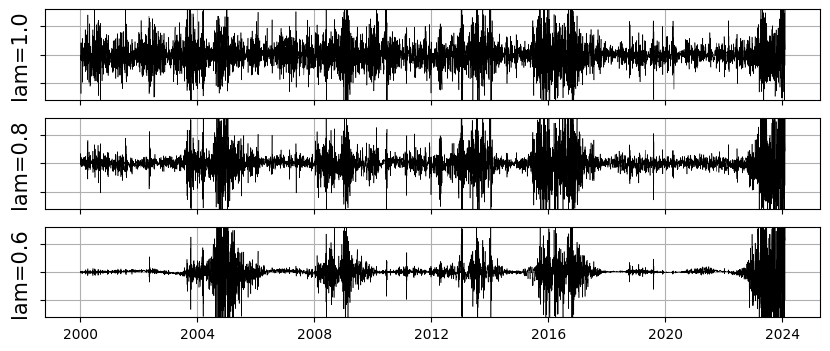

In [21]:
#
fig, axes = plt.subplots(len(x_gen_adjusted), 1, figsize=(10, 4))
for iax, x_gen_adj in enumerate(x_gen_adjusted):
    axes[iax].plot(data_snp.dts[:-1], x_gen_adj[0, 0, :], lw=0.4, color="black")
    axes[iax].set_ylabel(f"lam={lams[iax]}", fontsize=15)
for iax, ax in enumerate(axes):
    if iax < axes.size - 1:
        ax.set_xticklabels([])
    ylim = 0.04
    ax.set_ylim(-ylim, ylim)
    ax.grid(True)
    ax.set_yticklabels([])